# Evaluation
Evaluation of each text classifier will be based on accuracy, precison, recall, f1 score and confusion matrix. A heatmap based on the confusion will also be generated for visualisation purposes as reference. sklearn.metrics has a very useful classfication report feature that is able to print out each evaluation metric mentioned above.

Accuracy = True Positives + True Negatives / (True Positives + False Positives + True Negatives + False Negatives)              
Accuracy is the ratio of true positives and negatives to all predictions.

Precision = True Positives / (True Positives + False Positives)                                                                  
Precision is the ratio of true positives to all positive predictions.

Recall = (True Positives / (True Positives + False Negatives)                                                                    
Recall is the ratio of true positives to true positives and false negatives.

F-Score = 2 * ((Precision * Recall) / (Precision + Recall))                                                                      
F-Score is the weight average of Precision and Recall which takes into account false positives and negatives. It is especially useful for uneven class distributions.

In [57]:
import pandas as pd  
import numpy as np 
import tensorflow as tf 
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from spacy.util import minibatch
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, f1_score
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Data Preprocessing

In [2]:
#read data from csv.files
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

Checking for null values 

In [3]:
#check for null values in True
true_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [4]:
#check for null values in False
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [5]:
#check for unique values in True
true_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [6]:
#check for unique values in False
fake_df.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [7]:
#dropping irrelevant columns 
fake_df.drop(['date', 'subject'], axis=1, inplace=True)
true_df.drop(['date', 'subject'], axis=1, inplace=True)

In [8]:
#setting binary values, 0 for fake, 1 for true
fake_df['class'] = 0 
true_df['class'] = 1

Text(0, 0.5, 'Proportion of News Articles')

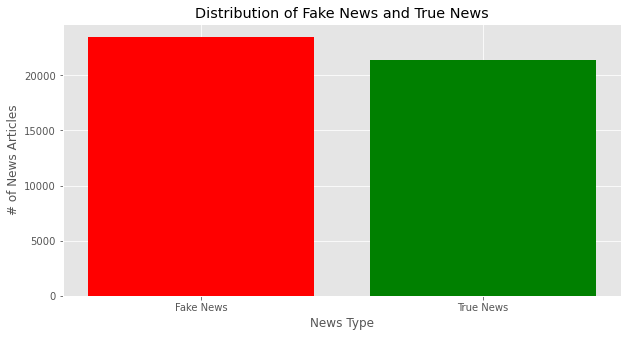

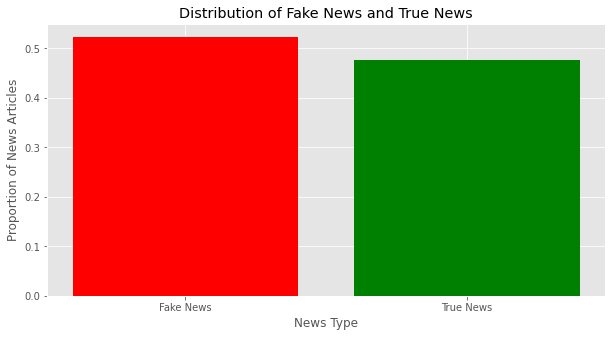

In [12]:
#graph to visualize distribution of dataset
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='red')
plt.bar('True News', len(true_df), color='green')
plt.title('Distribution of Fake News and True News')
plt.xlabel('News Type')
plt.ylabel('# of News Articles')


total_len = len(fake_df) + len(true_df)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df) / total_len, color='red')
plt.bar('True News', len(true_df) / total_len, color='green')
plt.title('Distribution of Fake News and True News')
plt.xlabel('News Type')
plt.ylabel('Proportion of News Articles')

In [15]:
#difference in true and fake news articles
print('Difference:',len(fake_df)-len(true_df))

Difference: 2064


In [16]:
news_df = pd.concat([fake_df, true_df], ignore_index=True, sort=False)
news_df

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1


In [17]:
#concatenating title and text  to form one large text for easier processing
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

In [25]:
#split to training and testing sets
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.25, random_state=11)

In [26]:
#removing white spaces, stopwords, url links and all lowercase
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

# Tokenization

In [27]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [28]:
# tokenize text to vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [29]:
#applying padding for consistent length
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

# RNN

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [31]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.25, batch_size=25, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1011/1011 [==============================] - 170s 165ms/step - loss: 0.2815 - accuracy: 0.8597 - val_loss: 0.1175 - val_accuracy: 0.9633
Epoch 2/10
1011/1011 [==============================] - 161s 159ms/step - loss: 0.0835 - accuracy: 0.9767 - val_loss: 0.0642 - val_accuracy: 0.9791
Epoch 3/10
1011/1011 [==============================] - 162s 160ms/step - loss: 0.0390 - accuracy: 0.9899 - val_loss: 0.0679 - val_accuracy: 0.9766
Epoch 4/10
1011/1011 [==============================] - 164s 163ms/step - loss: 0.0196 - accuracy: 0.9950 - val_loss: 0.0506 - val_accuracy: 0.9850
Epoch 5/10
1011/1011 [==============================] - 163s 161ms/step - loss: 0.0144 - accuracy: 0.9969 - val_loss: 0.0585 - val_accuracy: 0.9834
Epoch 6/10
1011/1011 [==============================] - 164s 162ms/step - loss: 0.0078 - accuracy: 0.9985 - val_loss: 0.0671 - val_accuracy: 0.9834
Epoch 7/10
1011/1011 [==============================] - 164s 162ms/step - loss: 0.0075 - accuracy: 0.9985 - val_

In [32]:
#evalutation
model.evaluate(X_test, y_test)

351/351 [==============================] - 15s 42ms/step - loss: 0.0428 - accuracy: 0.9865


[0.04280582442879677, 0.9864587783813477]

In [33]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

351/351 [==============================] - 16s 42ms/step


In [59]:
print('Accuracy:', accuracy_score(binary_predictions, y_test))
print('Precision:', precision_score(binary_predictions, y_test))
print('Recall:', recall_score(binary_predictions, y_test))
print('F-Score:', f1_score(binary_predictions, y_test))

Accuracy: 0.9864587973273942
Precision: 0.9814282979130767
Recall: 0.9893842887473461
F-Score: 0.9853902345251826


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

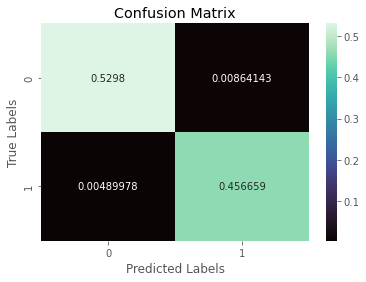

In [38]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure()
ax= plt.subplot()
sns.heatmap(matrix, annot = True, fmt = 'g', cmap = 'mako')

# labels, title and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

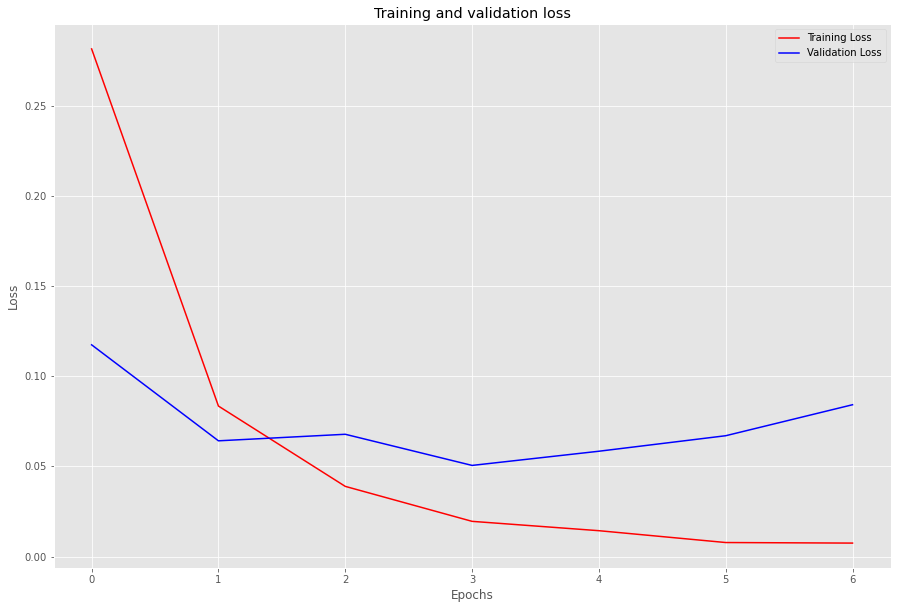

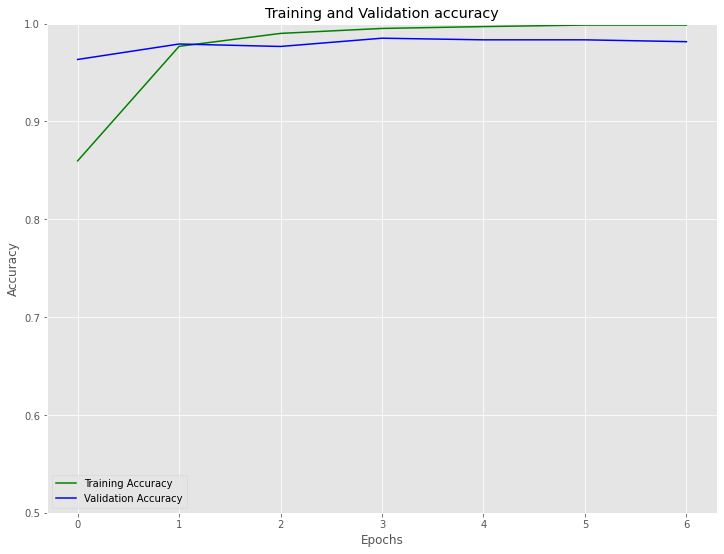

In [39]:
#training over time graph
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(prop={'size': 10})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(prop={'size': 10})
plt.ylim((0.5,1))
plt.show()

# Naive Bayes

	Naive Bayes Classifier Results

              precision    recall  f1-score   support

           0       0.59      0.60      0.60      6002
           1       0.54      0.53      0.53      5223

    accuracy                           0.57     11225
   macro avg       0.56      0.56      0.56     11225
weighted avg       0.57      0.57      0.57     11225



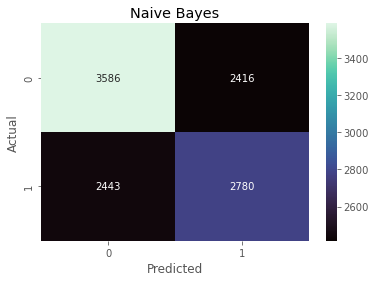

In [40]:
#naive bayes 
print("\tNaive Bayes Classifier Results\n")
nb = MultinomialNB().fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
cm_nb = confusion_matrix(y_test, y_pred_nb)
print(classification_report(y_test, y_pred_nb))
sns.heatmap(cm_nb, annot = True, fmt = 'g', cmap = 'mako')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Bayes')
plt.show()

# Logistic Regression

              precision    recall  f1-score   support

           0       0.62      0.65      0.63      6002
           1       0.58      0.55      0.56      5223

    accuracy                           0.60     11225
   macro avg       0.60      0.60      0.60     11225
weighted avg       0.60      0.60      0.60     11225



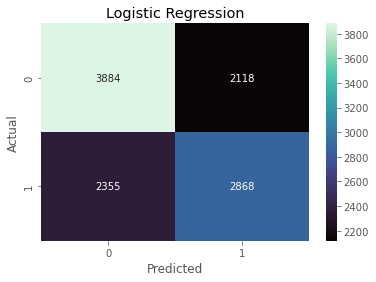

In [41]:
#logistic regression
lr = LogisticRegression(solver = 'liblinear')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(classification_report(y_test, y_pred_lr))
sns.heatmap(cm_lr, annot = True, fmt = 'g', cmap = 'mako')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression')
plt.show()

# Random Forest

	Random Forest Classifier Results

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      6002
           1       0.85      0.87      0.86      5223

    accuracy                           0.87     11225
   macro avg       0.87      0.87      0.87     11225
weighted avg       0.87      0.87      0.87     11225



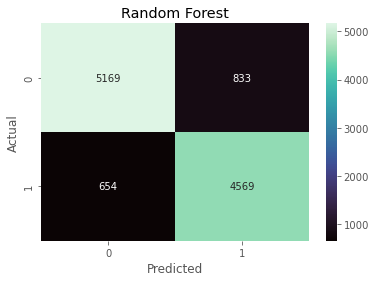

In [42]:
#random forest
print("\tRandom Forest Classifier Results\n")
rfc = RandomForestClassifier(random_state = 6) #try different random states for optimization
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
cm_rfc = confusion_matrix(y_test, y_pred_rfc)
print(classification_report(y_test, y_pred_rfc))
sns.heatmap(cm_rfc, annot = True, fmt = 'g', cmap = 'mako')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest')
plt.show()

# CNN

In [43]:
#cnn
cnn_model = tf.keras.Sequential()
cnn_model.add(layers.Reshape((256, 1), input_shape=(256,)))
cnn_model.add(layers.Conv1D(32, kernel_size=(3), activation = 'relu', input_dim=(X_train.shape[1])))
cnn_model.add(layers.MaxPooling1D(pool_size=2))
cnn_model.add(layers.Dense(units = 128 , activation = 'relu'))
cnn_model.add(layers.Dense(units = 64 , activation = 'relu'))
cnn_model.add(layers.Dense(units = 1 , activation = 'sigmoid'))

In [46]:
cnn_model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
cnn_history = cnn_model.fit(X_train, y_train, epochs=10,validation_split=0.25, batch_size=25, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1011/1011 [==============================] - 6s 5ms/step - loss: 0.6906 - accuracy: 0.5368 - val_loss: 0.6898 - val_accuracy: 0.5371
Epoch 2/10
1011/1011 [==============================] - 5s 5ms/step - loss: 0.6906 - accuracy: 0.5369 - val_loss: 0.6898 - val_accuracy: 0.5371
Epoch 3/10
1011/1011 [==============================] - 5s 5ms/step - loss: 0.6904 - accuracy: 0.5369 - val_loss: 0.6918 - val_accuracy: 0.5371
Epoch 4/10
1011/1011 [==============================] - 5s 5ms/step - loss: 0.6905 - accuracy: 0.5369 - val_loss: 0.6905 - val_accuracy: 0.5371
Epoch 5/10
1011/1011 [==============================] - 5s 5ms/step - loss: 0.6905 - accuracy: 0.5369 - val_loss: 0.6900 - val_accuracy: 0.5371


In [47]:
cnn_model.evaluate(X_test, y_test)

351/351 [==============================] - 1s 2ms/step - loss: 0.6894 - accuracy: 0.5481


[0.6893986463546753, 0.5481072664260864]

In [61]:
cnn_pred = cnn_model.predict(X_test)

cnn_binary_predictions = []

for i in cnn_pred:
    if i.any() >= 0.5:
        cnn_binary_predictions.append(1)
    else:
        cnn_binary_predictions.append(0)

351/351 [==============================] - 1s 2ms/step


In [62]:
print('Accuracy:', accuracy_score(cnn_binary_predictions, y_test))
print('Precision:', precision_score(cnn_binary_predictions, y_test))
print('Recall:', recall_score(cnn_binary_predictions, y_test))
print('F-Score:', f1_score(cnn_binary_predictions, y_test))

Accuracy: 0.46530066815144766
Precision: 1.0
Recall: 0.46530066815144766
F-Score: 0.6350924124513619


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

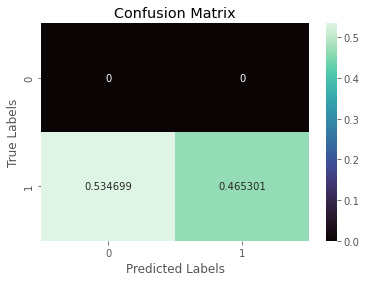

In [63]:
cnn_matrix = confusion_matrix(cnn_binary_predictions, y_test, normalize='all')
plt.figure()
ax= plt.subplot()
sns.heatmap(cnn_matrix, annot = True, fmt = 'g', cmap = 'mako')

# labels, title and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

In [58]:
#naive bayes
print("Naive Bayes Classifier Accuracy: ", '{:.2%}'.format(accuracy_score(y_test, y_pred_nb)))
print("Naive Bayes Classifier Precision: ", '{:.2%}'.format(precision_score(y_test, y_pred_nb)))
print("Naive Bayes Classifier Recall: ", '{:.2%}'.format(recall_score(y_test, y_pred_nb)))
print("Naive Bayes Classifier F1 Score: ", '{:.2%}'.format(f1_score(y_test, y_pred_nb)))

#Logistic Regression
print("\n")
print("Logistic Regression Accuracy: ", '{:.2%}'.format(accuracy_score(y_test, y_pred_lr)))
print("Logistic Regression Precision: ", '{:.2%}'.format(precision_score(y_test, y_pred_lr)))
print("Logistic Regression Recall: ", '{:.2%}'.format(recall_score(y_test, y_pred_lr)))
print("Logistic Regression F1 Score: ", '{:.2%}'.format(f1_score(y_test, y_pred_lr)))

#random forest
print("\n")
print("Random Forest Classifier Accuracy: ", '{:.2%}'.format(accuracy_score(y_test, y_pred_rfc)))
print("Random Forest Classifier Precision: ", '{:.2%}'.format(precision_score(y_test, y_pred_rfc)))
print("Random Forest Classifier Recall: ", '{:.2%}'.format(recall_score(y_test, y_pred_rfc)))
print("Random Forest Classifier F1 Score: ", '{:.2%}'.format(f1_score(y_test, y_pred_rfc)))

Naive Bayes Classifier Accuracy:  56.71%
Naive Bayes Classifier Precision:  53.50%
Naive Bayes Classifier Recall:  53.23%
Naive Bayes Classifier F1 Score:  53.36%


Logistic Regression Accuracy:  60.15%
Logistic Regression Precision:  57.52%
Logistic Regression Recall:  54.91%
Logistic Regression F1 Score:  56.19%


Random Forest Classifier Accuracy:  86.75%
Random Forest Classifier Precision:  84.58%
Random Forest Classifier Recall:  87.48%
Random Forest Classifier F1 Score:  86.00%
